In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

#Cuda 혹은 cpu를 사용하시오.
############Write Your Code Here############
from sklearn.model_selection import train_test_split
from torchvision import transforms
device = 'cuda'
############################################


class Custom_Dataset(Dataset):
    def __init__(self, X, y):
        #입력으로 들어온 X의 pixel값들을 0-1사이로 normalize하고 X의 shape을 (FB,C,H,W)로 변경하여 저장하여 self.X,self.y에 저장.
        self.X = None
        self.y = None
        X = X.astype('float32')
        X /= 255.0

        self.X = np.transpose(X, (0,3,1,2))
        self.y = y
        
    def __len__(self):
        result = 0
        result = len(self.X)
        return result
    
    def __getitem__(self, idx):
        result_X,result_y = None,None
        result_X = self.X[idx]
        result_y = self.y[idx]
        return result_X,result_y

    
#torch.nn을 사용하여 아래 함수들을 작성하시오. result는 nn.Layer중 하나이고 result를 반환함
def batch_norm(dim,for_MLP=True):
    #for_MLP가 True일 시 MLP를 위한 BN Layer를 반환하고 False일 시 CNN을 위한 BN Layer를 반환함.
    if for_MLP:
      result = nn.BatchNorm1d(dim)
    else:
      result = nn.BatchNorm2d(dim)
    return result

def fc_layer(in_dim,out_dim):
    #Fully Connected Layer(Dense Layer)
    result = torch.nn.Linear(in_dim, out_dim)
    return result

def conv_layer(in_ch,out_ch,kernel_size, stride=1, padding=0):
    #Convolutional Layer for image
    result = nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, padding=padding, bias=False)
    return result

def relu():
    #ReLU function
    result = nn.ReLU()
    return result

def flatten():
    #Flatten the data
    result = nn.Flatten()
    return result

#skip_connection(bn -> relu -> conv -> bn -> relu -> conv)를 따르는 Res_block.
#change_res가 True인 res_block을 통과한 feature map은 resolution이 2배 작아지고 channel의 깊이는 2배로 증가함. ex) 32*8*8 -> 64*4*4
#위의 경우에는 skip_connection의 dimension은 1*1 conv로 맞춰줌.
#change_res가 False인 Res_block을 통과한 feature map은 resolution과 channel의 깊이는 그대로 유지됨. ex) 32*4*4 -> 32*4*4(20점)
class Res_block(nn.Module):
    def __init__(self, input_channel, change_res):
        super(Res_block,self).__init__()
        self.change_res = change_res
        if change_res:
            self.conv1 = conv_layer(input_channel, input_channel*2, kernel_size=3, stride=2, padding=1)
            self.bn1= batch_norm(input_channel*2, for_MLP=False)
            self.shortcut = nn.Sequential(
                conv_layer(input_channel, input_channel*2, kernel_size=1, stride=2),
                batch_norm(input_channel*2, for_MLP=False)
            )
            input_channel = input_channel * 2
        else:
            self.conv1 = conv_layer(input_channel, input_channel, 3, 1, 1) #in_ch, out_ch, kernel, stride, padding
            self.bn1 = batch_norm(input_channel, for_MLP=False)
            self.shortcut = nn.Sequential()
        self.conv2 = conv_layer(input_channel, input_channel, 3, 1, 1)
        self.bn2 = batch_norm(input_channel, for_MLP=False)   
        self.relu = relu()
    def forward(self,X):
        out = self.relu(self.bn1(self.conv1(X)))
        out = self.bn2(self.conv2(out))
        #print(out.size(), X.size(), self.shortcut(X).size())
        out += self.shortcut(X)
        out = self.relu(out)
        X = out
        return X

    
#Skip Connection을 이용하여 20개 이상의 layer를 가지고 테스트 셋에대하여 50% 이상의 성능을 주는 MLP.
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP,self).__init__()
        self.flatten = flatten()
        self.relu = relu()
        self.dropout = nn.Dropout(0.2)


        self.linear1 = fc_layer(input_dim, 512)
        self.linear2 = fc_layer(512, 256)
        self.linear3 = fc_layer(256,256)
        self.linear4 = fc_layer(256,128)
        self.bn4 = batch_norm(128)
        self.linear5 = fc_layer(128, 128)
        self.linear6 = fc_layer(128, 64)
        self.bn5 = batch_norm(64)
        self.linear7 = fc_layer(64, 64)
        self.last_layer = fc_layer(64, 10)


    def forward(self,X):
        X = self.flatten(X)
        X = self.relu(self.linear1(X)) # 1
        X = self.dropout(X)
        X = self.relu(self.linear2(X)) # 2
        X = self.dropout(X)
        X = self.relu(self.linear3(X)) # 3
        out = X
        X = self.relu(self.linear3(X)) # 4
        X = self.relu(self.linear3(X)) # 5
        X = self.relu(self.linear3(X)) # 6
        X = self.linear3(X) # 7
        X += out
        X = self.relu(X)

        X = self.bn4(self.relu(self.linear4(X))) # 8
        out = X
        X = self.relu(self.linear5(X)) # 9
        X = self.relu(self.linear5(X)) # 10
        X = self.relu(self.linear5(X)) # 11
        X = self.linear5(X) # 12
        X += out
        X = self.relu(X)

        X = self.bn5(self.relu(self.linear6(X))) # 13
        out = X
        X = self.relu(self.linear7(X)) # 14
        X = self.relu(self.linear7(X)) # 15
        X = self.linear7(X) #16
        X += out
        X = self.relu(X)

        X = self.relu(self.linear7(X)) # 17 
        X = self.relu(self.linear7(X)) # 18
        X = self.linear7(X) # 19
        X += out
        X = self.relu(X)

        X = self.relu(self.last_layer(X)) # 20

        return X
        
#Res_Block을 사용하여 테스트 셋에대한 70% 이상의 성능을 주는 CNN 모델을 만드시오.
class CNN(nn.Module):
    def __init__(self, input_channel, class_number, block_number):
        super(CNN,self).__init__()
        self.conv1 = conv_layer(3, input_channel, kernel_size=3, stride=1, padding=1)
        self.bn1 = batch_norm(input_channel,for_MLP=False)
        self.layer1 = Res_block(input_channel, 0) 
        self.layer2 = Res_block(input_channel, 0)

        self.layer3 = Res_block(input_channel, change_res=True) # residual block => depth * 2
        self.layer4 = Res_block(input_channel*2, 0) 

        self.layer5 = Res_block(input_channel*2, change_res=True) # residual block => depth * 2
        self.layer6 = Res_block(input_channel*4, 0)

        self.layer7 = Res_block(input_channel*4, change_res=True) # residual block => depth * 2 
        self.layer8 = Res_block(input_channel*8, 0)

        self.linear = fc_layer(input_channel*8, class_number)  
        self.relu = relu()
    def forward(self,X):
        out = self.relu(self.bn1(self.conv1(X)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
  
        out = nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        X = out

        return X

def evaluate(model, loader):
    model.eval()
    accuracy = 0
    total_example = 0
    correct_example = 0
    for data in loader:
        x,y = data
        x = torch.tensor(x, device = device)
        y = torch.tensor(y, device = device)

        output = model(x)
        _, predicted = torch.max(output, 1)
        
        total_example += y.size(0)
        correct_example += (predicted == y).sum().item()
    accuracy = correct_example / total_example * 100

    model.train()
    return accuracy

#epoch마다 train_loader에 있는 batch들을 사용하여 모델을 학습하고
#epoch의 마지막 iteration에서는 모델의 validation accuracy를 확인하여 제일 높은 val. acc.를 가진 model을 best_model에 저장하고
#val_acc에는 매 epoch마다 구해진 validation accuracy를 저장
#running_loss에는 각각의 epoch에서 모든 batch의 loss를 다 더하여 저장
def train(model, epoches, train_loader, val_loader, optimizer, criteria, scheduler): # scheduler parameter를 추가해주어 learning rate을 변화시켜주었다.
    best_score = 0
    best_model = None
    batch_len = len(train_loader)
    val_acc = []
    for epoch in range(epoches):
        running_loss = 0
        for i,data in enumerate(train_loader):
            x,y = data
            x = torch.tensor(x, device = device)
            y = torch.tensor(y, device = device)
            optimizer.zero_grad()

            output = model(x)
            loss = criteria(output, y)
            loss.backward()
            optimizer.step()
            scheduler.step() 
            running_loss += loss.item()
            
            #epoch의 마지막 iteration
            if i % batch_len == batch_len-1:
                print(f'{epoch+1}th iteration loss :',running_loss/batch_len)
                running_loss = 0

                with torch.no_grad():
                  correct = 0
                  total = 0
                  for i, data in enumerate(val_loader):
                    val_x, val_y = data
                    val_x = torch.tensor(val_x, device = device)
                    val_y = torch.tensor(val_y, device = device)
                    val_out = model(val_x)
                    _, predicted = torch.max(val_out.data, 1)
                    total += val_y.size(0)
                    correct += (predicted == val_y).sum().item()
 

                accuracy = 100 * correct / total
                print("val acc :",accuracy)
                val_acc.append(accuracy)

                if best_score < accuracy:
                  best_score = accuracy
                  best_model = deepcopy(model)

    return best_model, val_acc

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:277: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1th iteration loss : 2.301500082015991


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:300: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


val acc : 10.56
2th iteration loss : 2.3019012749766388
val acc : 11.06
3th iteration loss : 2.301704881290277
val acc : 10.7
4th iteration loss : 2.3014594724003117
val acc : 10.99
5th iteration loss : 2.301380978605618
val acc : 10.52
6th iteration loss : 2.2998102655806862
val acc : 11.22
7th iteration loss : 2.2941185498770813
val acc : 13.68
8th iteration loss : 2.263877758964563
val acc : 19.15
9th iteration loss : 2.2139880223015247
val acc : 22.08
10th iteration loss : 2.174041961328671
val acc : 24.25
11th iteration loss : 2.1079120567431464
val acc : 26.05
12th iteration loss : 2.0462918041613154
val acc : 28.94
13th iteration loss : 2.0374445530553214
val acc : 26.35
14th iteration loss : 2.0171206286920906
val acc : 28.26
15th iteration loss : 1.9913805841257015
val acc : 29.46
16th iteration loss : 1.9729379087972183
val acc : 30.19
17th iteration loss : 1.9759961054347956
val acc : 30.72
18th iteration loss : 1.9521093159057081
val acc : 30.65
19th iteration loss : 1.9279

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:247: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:248: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


MLP accuracy: 53.16
CNN accuracy: 80.45


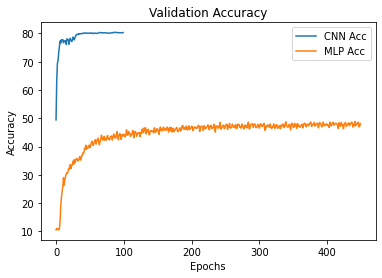

In [ ]:
#Read the data
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True)

X_train, Y_train = trainset.data, np.array(trainset.targets)
X_test, Y_test = testset.data, np.array(testset.targets)

#앞서 정의한 Custom_Dataset과 DataLoader를 사용하여 train_loader,val_loader,test_loader를 정의하시오.
#Batch_size는 본인의 컴퓨터 사향에 맞게 변경하면 됨. Validation Set으로 Train Set의 20%를 사용함.
#Preprocessing
train_loader = None
val_loader = None
test_loader = None
batch_size = 128

# data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

trainset.transform = transform_train
testset.transform = transform_test

X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1, stratify=Y_train)

train_dataset = Custom_Dataset(X_train, y_train) # load train Dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataset = Custom_Dataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
test_dataset = Custom_Dataset(X_test, Y_test) # load test Dataset
test_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers=2)


#앞서 정의한 MLP,CNN을 사용하여 mlp_model,cnn_model을 정의.
#Define the model
mlp_model = None
cnn_model = None
mlp_model = MLP(32*32*3, 10)
cnn_model = CNN(16, 10, 0)

criteria = nn.CrossEntropyLoss()

optimizer_mlp = torch.optim.SGD(mlp_model.parameters(), lr=0.1, momentum=0.9)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.1, momentum=0.9)

scheduler_mlp = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_mlp, T_max=30) # use cosineannealing scheduler for MLP, CNN
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)
#scheduler_mlp = torch.optim.lr_scheduler.MultiStepLR(optimizer_mlp, milestones=[100, 200], gamma=0.1)

mlp_model.to(device)
cnn_model.to(device)

#Train the model
best_mlp = None
mlp_val_acc = None
best_cnn = None
cnn_val_acc = None
best_mlp, mlp_val_acc = train(mlp_model, 450, train_loader, val_loader, optimizer_mlp, criteria, scheduler_mlp)
best_cnn, cnn_val_acc = train(cnn_model, 100, train_loader, val_loader, optimizer, criteria, scheduler)



#Test Accuracy
mlp_acc = None  
cnn_acc = None 
mlp_acc = evaluate(best_mlp, test_loader)
cnn_acc = evaluate(best_cnn, test_loader)
print('MLP accuracy:',mlp_acc)
print('CNN accuracy:',cnn_acc)


#Validation Accuracy Plot
plt.title("Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(cnn_val_acc, label="CNN Acc")
plt.plot(mlp_val_acc, label="MLP Acc")
plt.legend()